# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

# Lending Club Milestone 3

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### **Our Goals:**

- to predict the probability that a loan will be full returned plus interest rate by the end of the due date when the loan just be proved by lending company
- use the prob from (1) to calculate ROI
- compare predicted ROI with true ROI to see the benefit of our model (profit)
- use rejected loan data and accepted loan data to find discrimination among states

### **Data Description**

The data in this project comes from 2016 Lending club as row represents each loan and column represents features of each loan . Since the dataset is too large, we randomly select 2500 rows from each loan_status class (0,1) and each month, total 2500 $\times$ 12 $\times$ 2 rows

### **Datasets**

In accepted datasets, they contain information about the loans as well as personal description. 

For example, loan information contains loan amount, funded amount, interest rate, etc. Personal information contains employ title, length, annual income, purpose, state, etc. 

The other one is the rejected datasets. Since they only contain a few variables, we will not use it to fit the model. We probably will draw some plots based on rejected and accepted datasets to explore discrimination later. 


**Initial explorations:** 
- Check the names of variables in each dataset. 
- Explore whether variables contain missing value or strange characters. 

**Data cleaning: **
- Remove empty rows 
- Decide loan status as Y variable
- Delete columns that contain more than 10% missing rows. With too many missing data, it’s hard for these columns to give useful information. 
- Check the remaining variables with variable dictionaries. Delete variables that do not necessary in this project and/ or don’t have descriptions in the dictionaries. Also, some high correlated variables (average current balance, total highest credit limit, etc) will also be removed. Moreover, some variables, such as funded amount, last payment amount and total payment, etc, that are related to Y but can’t be used as X will be removed when fit model. But they will be reused when calculate ROI. 
- In the remaining dataset, change categorical variables to dummy variable. Remove strange characters (%, $) in each row. 
- Standardize all non-binary variables


# EDA

To label the dataset, we classified any loan that defaulted, were charged off, or were late on payments was classified as negative examples, while we classified any loan that was fully paid or current was classified as positive examples. However we are facing a class imbalance issue, so we sampled 2500 records from each months in each class (together we have 12 x 2500 x 2=60000 records).

A raw cleaning of data results in a table including these columns. Here we present the first record to illustrate the datatype of each feature.

In [3]:
cdf = pd.read_csv("../Data/cdf_update.csv") # baseline
cdf_raw = pd.read_csv("../Data/cdf_withJoint.csv") # balanced class
cdf.iloc[1]

loan_amnt                                   8000
funded_amnt                                 8000
term                                          36
int_rate                                   10.75
installment                               260.97
grade                                          B
emp_title                                 driver
emp_length                                     8
home_ownership                              RENT
annual_inc                                 34000
verification_status                            1
issue_d                                 Mar-2016
loan_status                                    1
purpose                       debt_consolidation
zip_code                                   910xx
addr_state                                    CA
dti                                        23.12
delinq_2yrs                                    1
earliest_cr_line                        Aug-2005
pub_rec                                        0
revol_util          

In [3]:
df = cdf.copy()
y_data = df["loan_status"]
# print(df["loan_status"].value_counts().values)
# print(cdf_raw['loan_status'].value_counts().values)

#   

### Principal Component Analysis

In [4]:
num_x_raw = df.loc[:,df.dtypes != "object"]

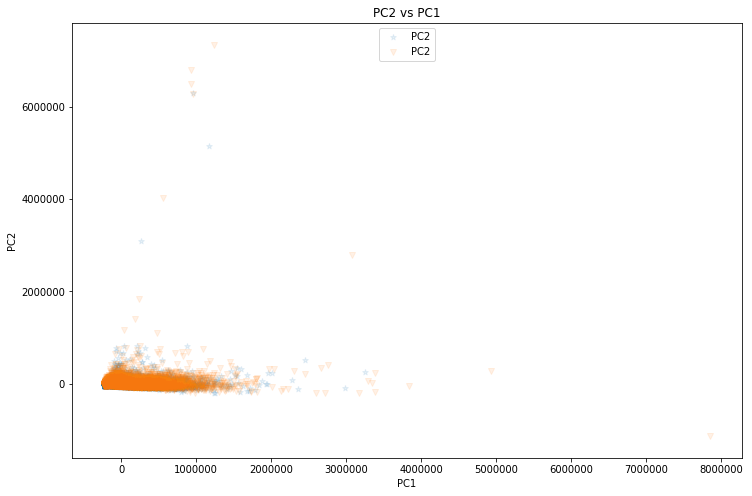

In [5]:
pca = PCA(n_components=2).fit(num_x_raw)
principalComponents = pca.transform(num_x_raw)
principalDf = pd.DataFrame(data = principalComponents, columns=["PC1","PC2"])
markers = ["*","v"]
plt.figure(figsize=[12,8])
for ylabel in [0,1]:
    df0 = principalDf[np.array(y_data) == ylabel]
    plt.scatter(x = df0["PC1"], y = df0["PC2"], marker = markers[ylabel], alpha = 0.1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='upper center')
plt.title("PC2 vs PC1")
plt.show()

Therefore PCA indicates that the data is not well-separable.

### Assessing Co-linearity

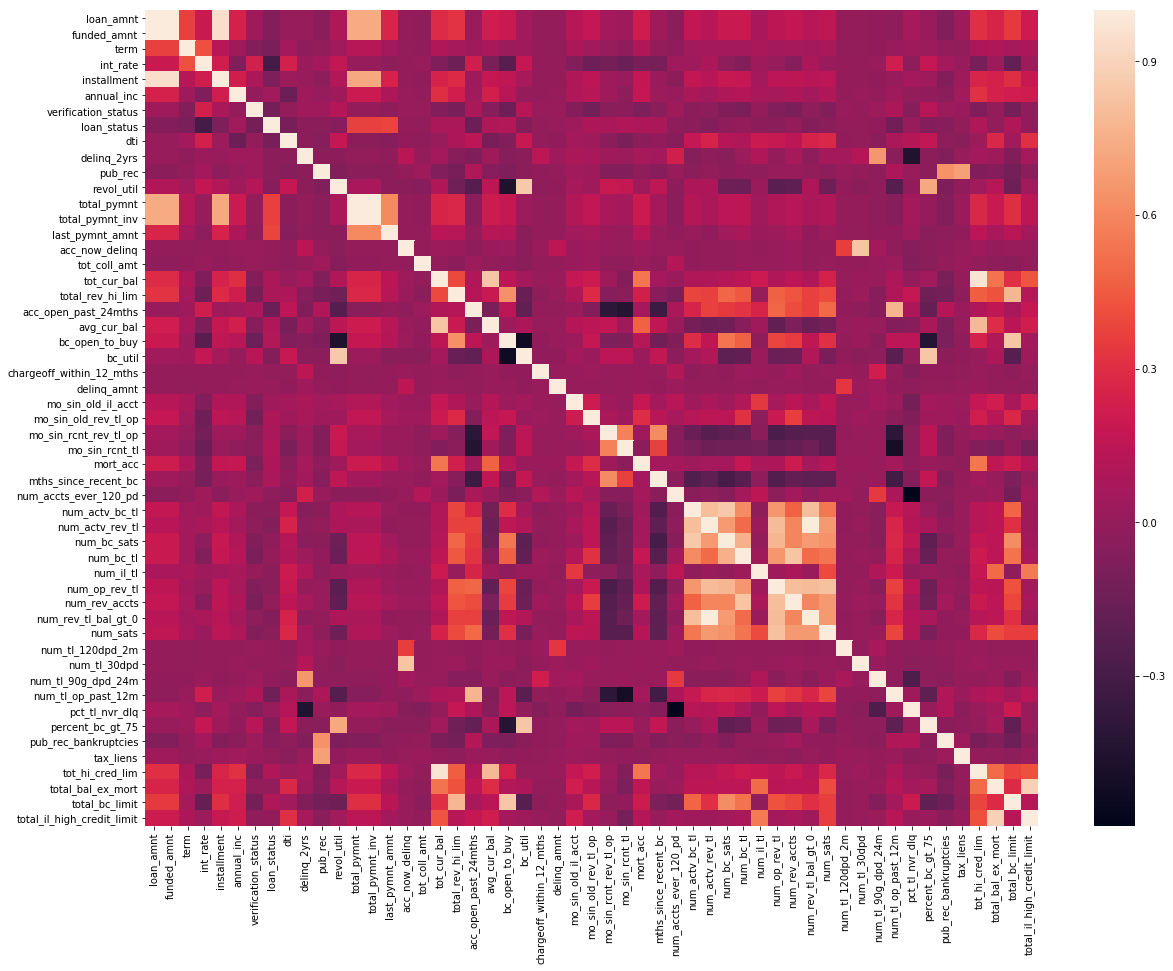

In [6]:
plt.figure(figsize = (20,15))
sns.heatmap(num_x_raw.corr())
plt.show()

It seems that for the revolving account we are having problem with colinearity. We later proposed to remove feature that has > 0.7 correlation with any other feature.

### Summarising features

Here we want to see what features have different distribution between two classes, those features might be of predictive value, or be directly related to loan status class itself. The latter one is really problematic.

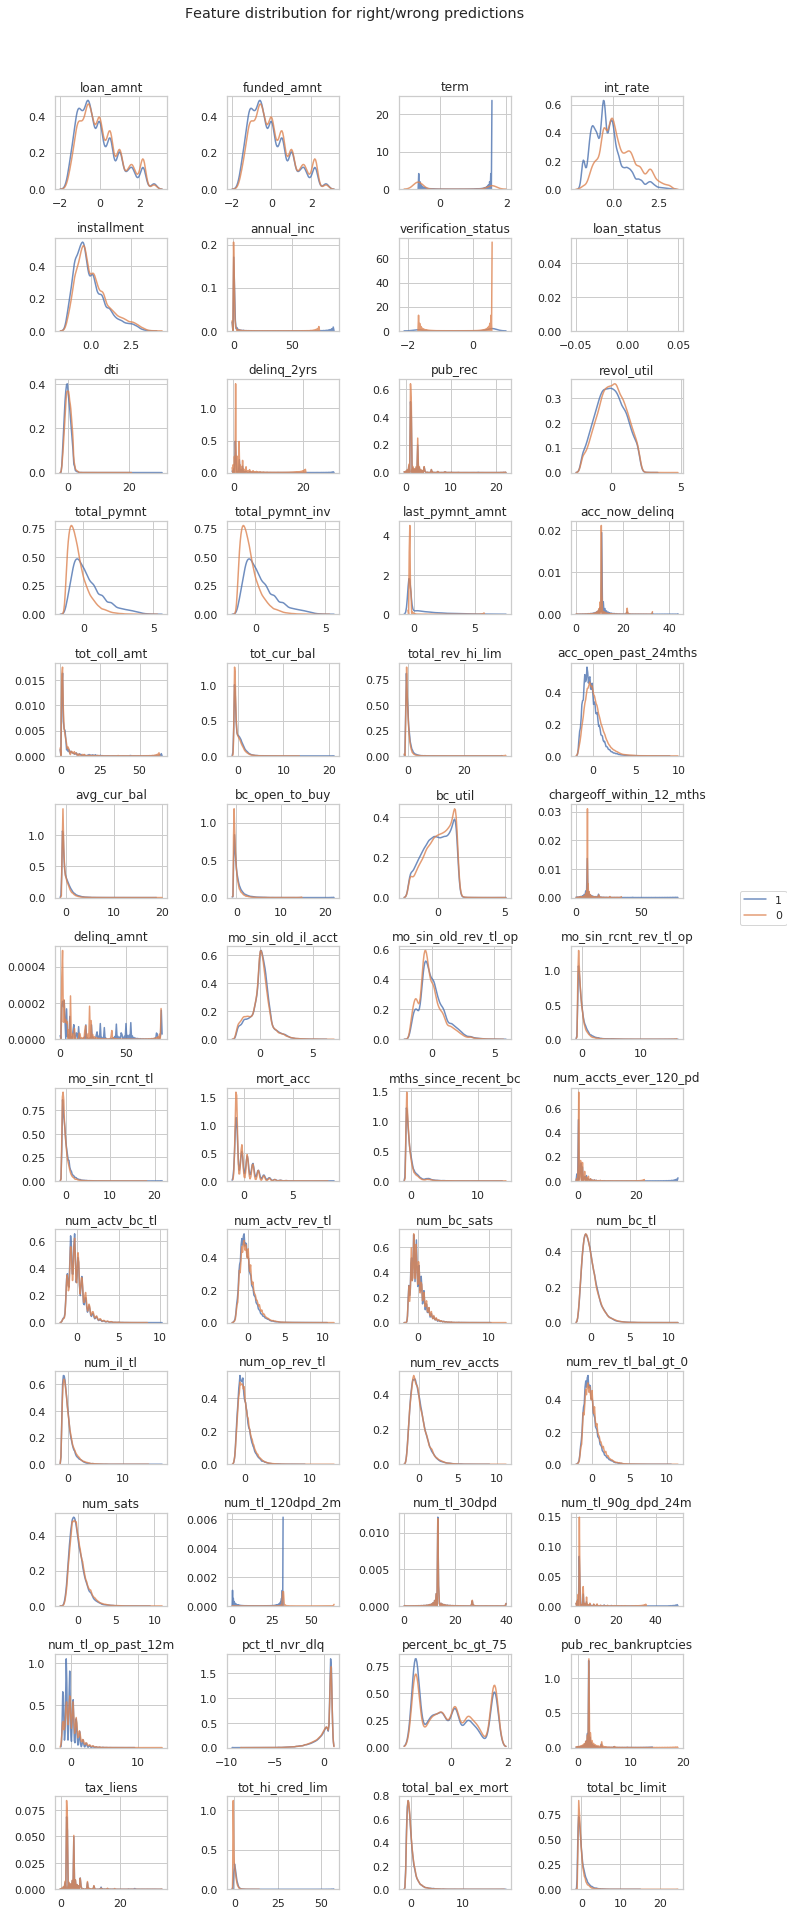

In [26]:
from sklearn.preprocessing import StandardScaler

if_right = np.array(y_data) == 1
nparr = np.array(num_x_raw)
columns = num_x_raw.columns.tolist()


min_max_scaler = StandardScaler()
nparr = min_max_scaler.fit_transform(nparr)

fig, axs = plt.subplots(ncols=4, nrows=13, figsize = [10,28],sharex=False)
axs = axs.flatten()
for i, ax in enumerate(axs):
    predictor = nparr[:,i]
    pname = columns[i]
    d1 = predictor[if_right]
    d2 = predictor[np.logical_not(if_right).tolist()]
    ax.set_title(pname)
    sns.kdeplot(ax=ax, data=d1,label="1", alpha=0.8)
    sns.kdeplot(ax=ax, data=d2, label="0", alpha=0.8)
    ax.get_legend().set_visible(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.1, 0.5))
fig.suptitle("Feature distribution for right/wrong predictions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.subplots_adjust(left=0.5, bottom=0, right=1, top=1.5, wspace=0.5, hspace=0.5)
plt.show()

Here we identified some variables that could never be obtained when a loan was initiated (posted on lending club), like last_payment_amount, total_payment. We must not include them in the model.

### Feature exploration

- **Q1: Loan status distribution in each state?**

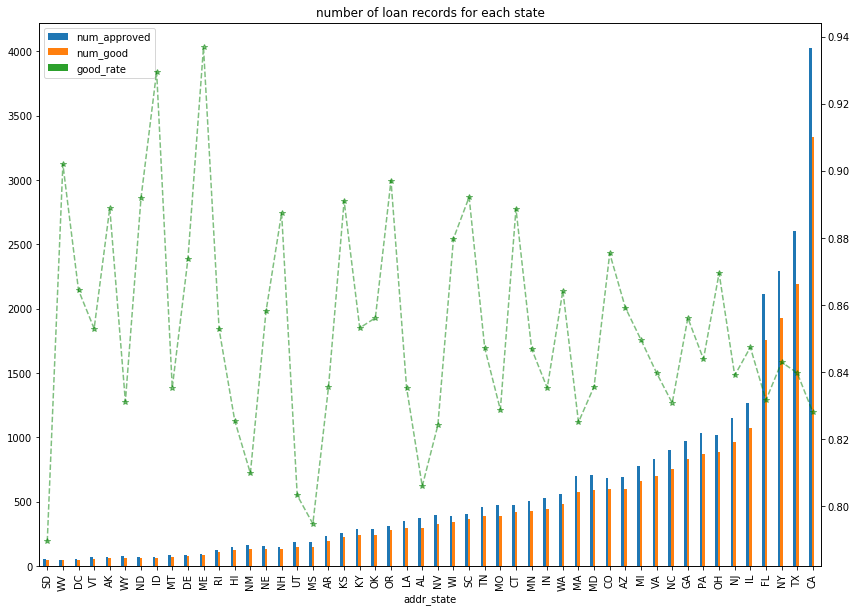

In [8]:
num_of_approved = cdf_raw.groupby("addr_state").count()["loan_amnt"]
num_of_good_status = cdf_raw.groupby("addr_state").sum()["loan_status"]
df_state = pd.concat([num_of_approved, num_of_good_status], axis=1)
df_state = df_state.rename(index=str, columns={"loan_status": "num_good", "loan_amnt": "num_approved"})
df_state = df_state.sort_values(by=['num_good'])
df_state["good_rate"] = df_state["num_good"]/df_state["num_approved"]

fig, ax1 = plt.subplots()
df_state.plot.bar(figsize=(14,10), title="number of loan records for each state", ax=ax1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(df_state["good_rate"],  'g--*', alpha=0.5)
plt.show()

There seems some discrimination among states. For example, CA receives the most loans but it does not have nice rate of returning money in time. It might be due to the population imbalance in each state, but there might be other attributable causes. We will assess that further.

- **Q2: How credit level and annual income relates to loan status?**

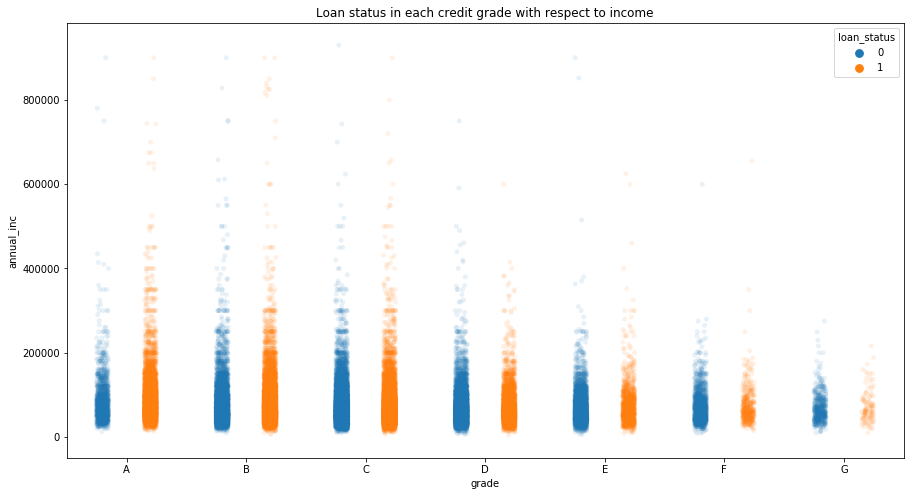

In [9]:
df_cut = df[df["annual_inc"]<1000000]
plt.figure(figsize=[15,8])
sns.stripplot(x="grade", y="annual_inc", hue=y_data, 
              data=df_cut, jitter=True, alpha=0.1, dodge=True,
              order=['A','B','C','D','E','F','G'])
plt.title("Loan status in each credit grade with respect to income")
plt.show()

From this plot we could see that, higher income does not necessarily indicates higher credit grade.
For first two classes (A and B), there are more successful returns (1) than unseccessful ones (0). The proportion of 0 and 1 are getting equal in credit class C but 0 is more frequent than 1 in later credit categories. 

**Q3: How home ownership affects initial rate, and final loan status?**

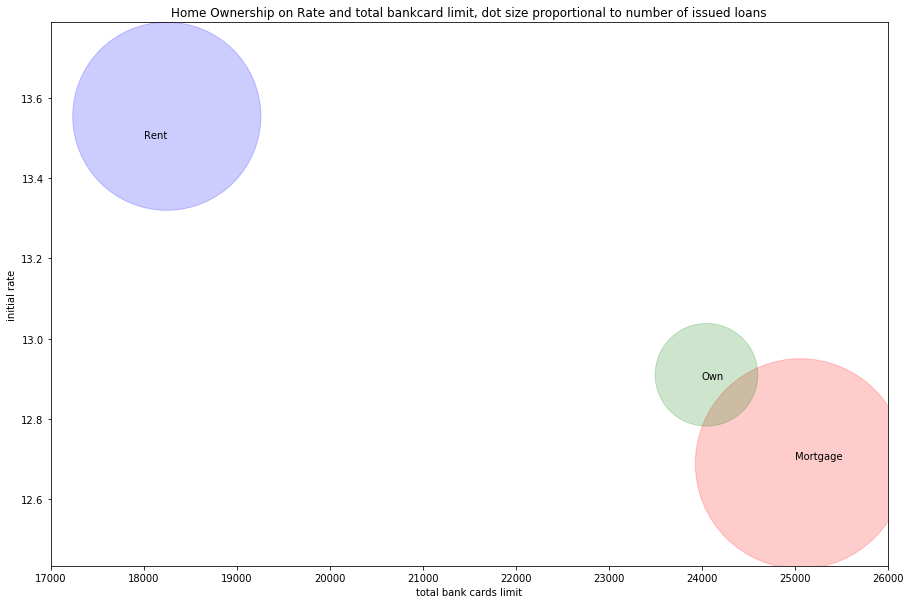

In [10]:
df_home = cdf_raw.groupby("home_ownership").mean()[["int_rate","total_bc_limit"]]
df_home["number"] = cdf_raw["home_ownership"].value_counts()
plt.figure(figsize=[15,10])
plt.xlim([17000, 26000])
plt.scatter(df_home["total_bc_limit"],df_home["int_rate"], 
            s = df_home["number"]*3, alpha = 0.2, c=['r','g','b']
           )
plt.text(x=18000, y = 13.5, s = "Rent")
plt.text(x=24000, y = 12.9, s = "Own")
plt.text(x=25000, y = 12.7, s = "Mortgage")
plt.title("Home Ownership on Rate and total bankcard limit, dot size proportional to number of issued loans")
plt.xlabel("total bank cards limit")
plt.ylabel("initial rate")
plt.show()

Here we could see that, the people who owned their house or put houses on mortgage are having smaller rate compared to those who rent their house. Maybe they are belived to have better budgeting habits. The majority of people who are approved for lending club are in either mortgage of rent category.

# Baseline Model

### Decision Tree

Due to the imbalance situation in our original dataset, we tend to test the model performance on both accuracy and ROC, and train the model based on equal sampling from 1 and 0 loan status class.

We built a decision tree model on the training set. We chose 5 as the maximum depth  based on cross validation. We got 65% accuracy on the test set. 

In [11]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [12]:
# data = pd.read_csv('data/cdf_withJoint.csv')
gen_data = pd.read_csv('cdf_withJoint.csv')
data = pd.read_csv("../Preprocess/cdf_update.csv")

In [13]:
def LD_data_cleaning(df, outcome_transform = False):
    
    from sklearn.utils import shuffle
    
    di = {"Charged Off": 0, 
      'Current': 1, 
      'Default':0, 
      'Fully Paid':1,
      'In Grace Period':0, 
      'Late (16-30 days)':0, 
      'Late (31-120 days)':0}
    
    if outcome_transform: df = df.replace({"loan_status": di})
    
    dt_cols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime, errors = 'coerce')
    
    df['issue_month'] = pd.DatetimeIndex(df['issue_d']).month
    df['issue_month'] = df['issue_month'].apply(lambda x: calendar.month_abbr[x])
    df['earliest_cr_year'] = pd.DatetimeIndex(df['earliest_cr_line']).year
    
    drop_cols = ["issue_d","earliest_cr_line", # extract the issue month and earliest credit year
                 
                 # columns related to the outcome
                 "last_pymnt_d","last_credit_pull_d",
                 "total_pymnt_inv","last_pymnt_amnt",
                 "total_pymnt", "funded_amnt", "installment", 
                 
                 # using addr_state instead
                 "zip_code", 
                 
                 # temporately unable to phrase
                 "emp_title", 
                 
                 # covariates of high correlations (>0.7)
                 "avg_cur_bal", "tot_hi_cred_lim",
                 "revol_util","num_actv_bc_tl","num_op_rev_tl","num_bc_tl", 
                 "num_rev_tl_bal_gt_0","num_tl_30dpd", 
                 "percent_bc_gt_75","bc_open_to_buy", "total_bal_ex_mort",
                 "mo_sin_old_rev_tl_op","num_tl_op_past_12m","pub_rec","total_rev_hi_lim"]
    
    df = df.drop(drop_cols, axis = 1)
    
    dummy_cols = ['grade',
              'emp_length',
              'home_ownership',
              'purpose','addr_state',
              'application_type',
              'hardship_flag', 
              'debt_settlement_flag',
              'issue_month',
              'loan_status']
    
    nonbinary_cols = df.columns.difference(dummy_cols)
    scaler = StandardScaler().fit(df[nonbinary_cols])
    df[nonbinary_cols] = scaler.transform(df[nonbinary_cols])
    
    df_train, df_test = train_test_split(df, test_size=.5, 
                                         stratify=df[['loan_status']],
#                                         stratify=df[['loan_status','addr_state']], 
                                         random_state=123)
    
    df_train = pd.get_dummies(df_train, columns = dummy_cols[:-1], drop_first = True)
    
    df_test = pd.get_dummies(df_test, columns = dummy_cols[:-1], drop_first = True)
    
    X_train= df_train.drop(["loan_status"],axis = 1).values
    y_train= df_train["loan_status"].values
    X_test= df_test.drop(["loan_status"], axis = 1).values
    y_test= df_test["loan_status"].values
    
    X_train, y_train = shuffle(X_train, y_train, random_state=123)
    X_test, y_test = shuffle(X_test, y_test, random_state=123)
    
    return df_train, df_test, X_train, y_train, X_test, y_test


In [14]:
df_train, df_test, X_train, y_train, X_test, y_test = LD_data_cleaning(data, outcome_transform = False)
gen_df_train, gen_df_test, X_gen_train, y_gen_train, X_gen_test, y_gen_test = LD_data_cleaning(gen_data, outcome_transform = False)

In [15]:
from sklearn.metrics import roc_auc_score

depths = range(2,30)
dt_var_scores_mean = []
dt_scores_train = []

dt_roc_auc_score_train = []
dt_roc_auc_score_test = []

for depth in depths:
    dt = DecisionTreeClassifier(max_depth = depth)
    dt.fit(X_train, y_train)
    dt_var_scores_mean.append(cross_val_score(dt, X_train, y_train, cv=5).mean())
    dt_scores_train.append(dt.score(X_train, y_train))
    
    dt_roc_auc_score_train.append(roc_auc_score(y_train, dt.predict(X_train)))
    dt_roc_auc_score_test.append(roc_auc_score(y_test, dt.predict(X_test)))

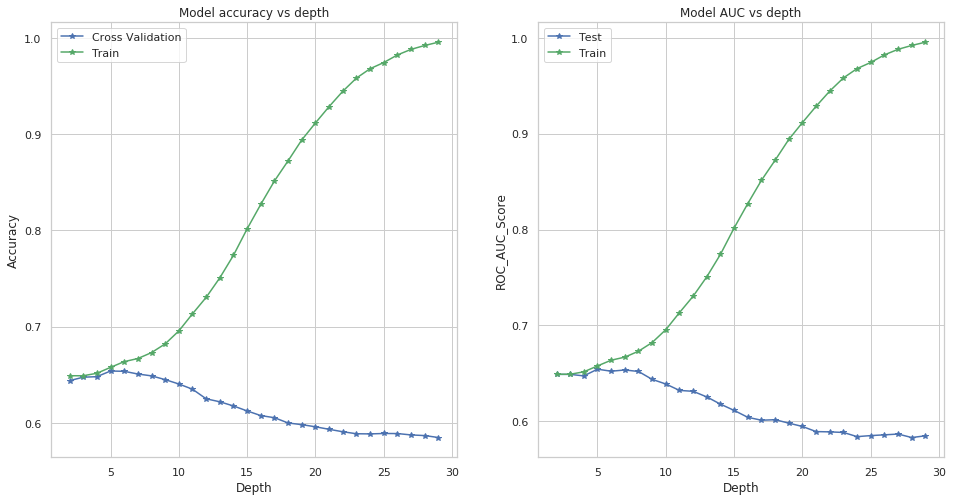

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (16,8), sharex=False)

axs[0].plot(depths, dt_var_scores_mean, 'b*-', label = 'Cross Validation')
axs[0].plot(depths, dt_scores_train, 'g*-', label = 'Train')
axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].set_title("Model accuracy vs depth")

axs[1].plot(depths, dt_roc_auc_score_test, 'b*-', label = 'Test')
axs[1].plot(depths, dt_roc_auc_score_train, 'g*-', label = 'Train')
axs[1].set_xlabel('Depth')
axs[1].set_ylabel('ROC_AUC_Score')
axs[1].legend()
axs[1].set_title("Model AUC vs depth")

plt.show()

In [17]:
depth_var_score = dt_var_scores_mean.index(max(dt_var_scores_mean)) + 2
depth_roc = dt_roc_auc_score_test.index(max(dt_roc_auc_score_test)) + 2
print("The selected depth from validation accuracy is {}, The selected depth from optimising AUC on test set is also {}".format(depth_var_score, depth_roc))

The selected depth from validation accuracy is 5, The selected depth from optimising AUC on test set is also 5


In [18]:
dt_best_model = DecisionTreeClassifier(max_depth = depth_roc).fit(X_train,y_train)
dt_score_train = dt_best_model.score(X_train,y_train)
dt_score_test = dt_best_model.score(X_test,y_test)

print("The model predicts train set with accuracy {}, test set with accuracy {}, and gives max AUC {} in cross-validation".format(dt_score_train, dt_score_test, max(dt_roc_auc_score_test)))

The model predicts train set with accuracy 0.6576666666666666, test set with accuracy 0.6542666666666667, and gives max AUC 0.6542666666666667 in cross-validation


In [19]:
X_df = df_train.drop(["loan_status"], axis = 1)
ind_order_dt_cv = np.argsort(dt_best_model.feature_importances_)[::-1]
sel_vars = X_df.columns[ind_order_dt_cv][:7].tolist()

print("decision tree selected: " + ", ".join(sel_vars) + "as important predictors")

decision tree selected: int_rate, debt_settlement_flag_Y, acc_open_past_24mths, mort_acc, mo_sin_rcnt_tl, hardship_flag_Y, tot_cur_balas important predictors
